# Comprehensive Data Analysis & Cluster Analysis
## Search History Deep Dive with Advanced Clustering Techniques

This notebook provides a robust analysis of Google search history data, including:
- **Data Quality Assessment**: Missing values, data types, temporal coverage
- **Descriptive Statistics**: Search patterns, frequency distributions, temporal trends
- **Cluster Analysis**: K-means, hierarchical clustering, and NLTK-based semantic clustering
- **Visualization**: Temporal patterns, cluster distributions, keyword analysis
- **Actionable Insights**: User interest profiles, search behavior patterns, cluster interpretations

In [2]:
%pip install -q -r requirements.txt
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter, defaultdict
import re
from urllib.parse import urlparse, parse_qs, unquote
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [ ]:
#run twice to verify if downloaded
!python /Users/shreyasjagannath/dev/fabric/onfabric-data-science-interview/download_nltk_data.py

In [ ]:
## Section 1: Data Loading & Initial Exploration

Total records: 55383

DataFrame shape: (55383, 9)


In [3]:
# Load the JSON file
with open('search_history.json', 'r') as f:
    search_data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(search_data)

print(f"{'='*80}")
print(f"DATA LOADING SUMMARY")
print(f"{'='*80}")
print(f"\n📊 Total records: {len(df):,}")
print(f"📏 DataFrame shape: {df.shape}")
print(f"📅 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few records
print(f"\n{'─'*80}")
print(f"First 3 records:")
print(f"{'─'*80}")
df.head(3)

DATA LOADING SUMMARY

📊 Total records: 55,383
📏 DataFrame shape: (55383, 9)
📅 Memory usage: 35.75 MB

────────────────────────────────────────────────────────────────────────────────
First 3 records:
────────────────────────────────────────────────────────────────────────────────


,header,title,titleUrl,time,products,activityControls,locationInfos,subtitles,details
0,Search,Visited https://www.businessinsider.com/shivon...,https://www.google.com/url?q=https://www.busin...,2024-06-23T22:21:50.431Z,[Search],[Web & App Activity],NaN,NaN,NaN
1,Search,Visited Elon Musk and Shivon Zilis privately w...,https://www.google.com/url?q=https://www.nbcph...,2024-06-23T22:20:53.934Z,[Search],[Web & App Activity],NaN,NaN,NaN
2,Search,Searched for elon musk shivon zilis,https://www.google.com/search?q=elon+musk+shiv...,2024-06-23T22:20:47.560Z,[Search],[Web & App Activity],"[{'name': 'At this general area', 'url': 'http...",NaN,NaN


In [ ]:
## Section 2: Data Cleaning & Feature Engineering

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55383 entries, 0 to 55382
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   header            55383 non-null  object
 1   title             55383 non-null  object
 2   titleUrl          55021 non-null  object
 3   time              55383 non-null  object
 4   products          55383 non-null  object
 5   activityControls  55383 non-null  object
 6   locationInfos     226 non-null    object
 7   subtitles         166 non-null    object
 8   details           2794 non-null   object
dtypes: object(9)
memory usage: 3.8+ MB


In [5]:
# Data cleaning and feature engineering
def extract_search_query(title):
    """Extract search query from title field"""
    if not title or not isinstance(title, str):
        return None
    
    search_match = re.search(r'^Searched for (.+?)(?:\s*$|[\?&])', title)
    if search_match:
        return search_match.group(1).strip()
    return None

def classify_activity(record):
    """Classify activity type"""
    title = record.get('title', '')
    if title.startswith('Searched for'):
        return 'search_query'
    elif title.startswith('Visited'):
        return 'page_visit'
    elif 'notification' in title.lower():
        return 'notification'
    else:
        return 'other'

def extract_domain(url):
    """Extract domain from URL"""
    try:
        return urlparse(url).netloc if url else None
    except:
        return None

# Apply transformations
df['activity_type'] = df.apply(classify_activity, axis=1)
df['search_query'] = df['title'].apply(extract_search_query)
df['timestamp'] = pd.to_datetime(df['time'], format='ISO8601', utc=True)
df['domain'] = df['titleUrl'].apply(extract_domain)

# Add temporal features
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['week'] = df['timestamp'].dt.isocalendar().week
df['month'] = df['timestamp'].dt.month

# Clean text fields
df['title_clean'] = df['title'].str.replace(r'Searched for |Visited ', '', regex=True)
df['title_clean'] = df['title_clean'].str.strip()

print(f"{'='*80}")
print(f"DATA CLEANING SUMMARY")
print(f"{'='*80}")
print(f"\n✓ Feature engineering complete")
print(f"✓ Added temporal features: date, hour, day_of_week, week, month")
print(f"✓ Added activity classification: {df['activity_type'].nunique()} types")
print(f"✓ Extracted search queries and domains")

print(f"\n📊 Activity Type Distribution:")
activity_counts = df['activity_type'].value_counts()
for activity, count in activity_counts.items():
    print(f"   {activity:.<20} {count:>8,} ({count/len(df)*100:>5.1f}%)")

print(f"\n📅 Temporal Coverage:")
print(f"   Start: {df['timestamp'].min()}")
print(f"   End:   {df['timestamp'].max()}")
print(f"   Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

print(f"\n🔗 Top 10 Domains:")
top_domains = df['domain'].value_counts().head(10)
for domain, count in top_domains.items():
    if domain:
        print(f"   {domain:.<40} {count:>6,}")
    else:
        print(f"   {'(no domain)':.<40} {count:>6,}")

DATA CLEANING SUMMARY

✓ Feature engineering complete
✓ Added temporal features: date, hour, day_of_week, week, month
✓ Added activity classification: 4 types
✓ Extracted search queries and domains

📊 Activity Type Distribution:
   search_query........   30,542 ( 55.1%)
   page_visit..........   22,496 ( 40.6%)
   other...............    2,187 (  3.9%)
   notification........      158 (  0.3%)

📅 Temporal Coverage:
   Start: 2017-06-08 16:42:55.223000+00:00
   End:   2024-06-23 22:21:50.431000+00:00
   Duration: 2572 days

🔗 Top 10 Domains:
   www.google.com.......................... 52,714
   local.google.com........................  1,862
   www.youtube.com.........................    126
   m.youtube.com...........................    106
   www.google.co.uk........................     78
   maps.google.co.uk.......................     22
   maps.google.com.........................     15
   books.google.com........................     14
   support.google.com......................  

In [ ]:
## Section 3: Data Quality & Missing Value Analysis

Unique headers: ['Search']

Value counts for 'header' column:


header
Search    55383
Name: count, dtype: int64

In [8]:
# Data quality assessment
print(f"{'='*80}")
print(f"DATA QUALITY ASSESSMENT")
print(f"{'='*80}")

# Missing values analysis
print(f"\n📊 Missing Values Analysis:")
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("   ✓ No missing values detected!")

# Duplicate analysis - simplified
print(f"\n🔍 Duplicate Records Analysis:")
print(f"   (Skipped due to complex data types in dataset)")

# Data type summary
print(f"\n📝 Data Type Summary:")
dtype_summary = df.dtypes.value_counts()
for dtype, count in dtype_summary.items():
    print(f"   {str(dtype):.<30} {count:>3} columns")

print(f"\n✅ Data quality check complete!")

DATA QUALITY ASSESSMENT

📊 Missing Values Analysis:
       Column  Missing_Count  Missing_Percentage
    subtitles          55217               99.70
locationInfos          55157               99.59
      details          52589               94.96
 search_query          24848               44.87
     titleUrl            362                0.65
       domain            362                0.65

🔍 Duplicate Records Analysis:
   (Skipped due to complex data types in dataset)

📝 Data Type Summary:
   object........................  15 columns
   int32.........................   2 columns
   datetime64[ns, UTC]...........   1 columns
   UInt32........................   1 columns

✅ Data quality check complete!


## Section 4: Descriptive Statistics & Temporal Analysis

In [9]:
# Temporal analysis and statistics
print(f"{'='*80}")
print(f"TEMPORAL PATTERNS & DESCRIPTIVE STATISTICS")
print(f"{'='*80}")

# Hourly distribution
print(f"\n⏰ Activity Distribution by Hour of Day:")
hourly_dist = df['hour'].value_counts().sort_index()
for hour, count in hourly_dist.items():
    bar_length = int(count / hourly_dist.max() * 40)
    print(f"   {hour:2d}:00 │ {'█' * bar_length} {count:5,}")

# Day of week distribution
print(f"\n📅 Activity Distribution by Day of Week:")
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in day_order:
    count = (df['day_of_week'] == day).sum()
    pct = count / len(df) * 100
    bar_length = int(pct / 3)
    print(f"   {day:.<15} {count:>6,} ({pct:>5.1f}%) │ {'█' * bar_length}")

# Search query statistics
print(f"\n🔍 Search Query Statistics:")
search_df = df[df['activity_type'] == 'search_query']
print(f"   Total searches: {len(search_df):,}")
print(f"   Unique searches: {search_df['search_query'].nunique():,}")
print(f"   Unique searches %: {search_df['search_query'].nunique()/len(search_df)*100:.1f}%")

if len(search_df) > 0:
    print(f"\n   📝 Top 15 Most Common Searches:")
    top_searches = search_df['search_query'].value_counts().head(15)
    for idx, (query, count) in enumerate(top_searches.items(), 1):
        query_display = query[:50] + "..." if len(query) > 50 else query
        print(f"      {idx:2d}. {query_display:.<55} {count:>5,} times")

# Page visit statistics
print(f"\n🌐 Page Visit Statistics:")
visit_df = df[df['activity_type'] == 'page_visit']
print(f"   Total page visits: {len(visit_df):,}")
print(f"   Unique pages visited: {visit_df['titleUrl'].nunique():,}")
print(f"   Pages revisited %: {(1 - visit_df['titleUrl'].nunique()/len(visit_df))*100:.1f}%")


TEMPORAL PATTERNS & DESCRIPTIVE STATISTICS

⏰ Activity Distribution by Hour of Day:
    0:00 │ ████   397
    1:00 │ █   171
    2:00 │ █   118
    3:00 │     84
    4:00 │ ██   198
    5:00 │ █████████   845
    6:00 │ ███████████████████████ 2,134
    7:00 │ ███████████████████████████████ 2,857
    8:00 │ ██████████████████████████████████████ 3,497
    9:00 │ █████████████████████████████████████ 3,435
   10:00 │ ██████████████████████████████████████ 3,472
   11:00 │ ████████████████████████████████████ 3,286
   12:00 │ ████████████████████████████████████ 3,312
   13:00 │ █████████████████████████████████████ 3,398
   14:00 │ ████████████████████████████████████████ 3,624
   15:00 │ ██████████████████████████████████████ 3,462
   16:00 │ ██████████████████████████████████ 3,125
   17:00 │ █████████████████████████████ 2,633
   18:00 │ ███████████████████████████ 2,507
   19:00 │ ███████████████████████████████ 2,870
   20:00 │ ██████████████████████████████████████ 3,485
   21:00

## Section 5: Visualization - Temporal Patterns

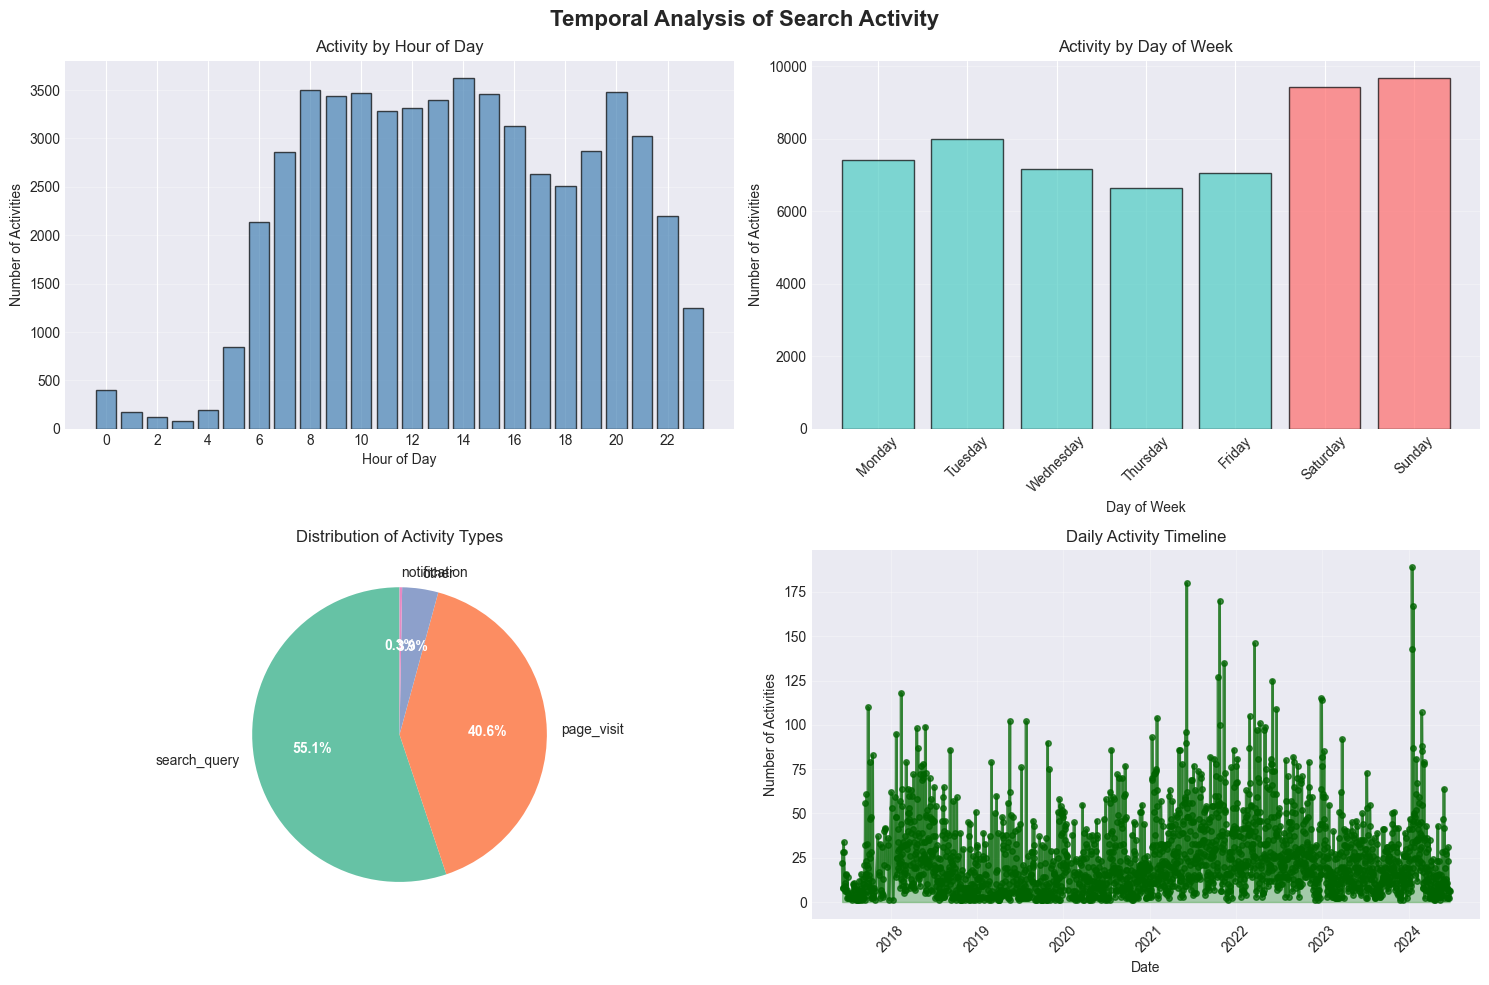

✓ Temporal visualizations created successfully!


In [10]:
# Create temporal visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Temporal Analysis of Search Activity', fontsize=16, fontweight='bold')

# 1. Hourly distribution
hourly_data = df['hour'].value_counts().sort_index()
axes[0, 0].bar(hourly_data.index, hourly_data.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Activities')
axes[0, 0].set_title('Activity by Hour of Day')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. Day of week distribution
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = [int((df['day_of_week'] == day).sum()) for day in day_order]
colors = ['#FF6B6B' if day in ['Saturday', 'Sunday'] else '#4ECDC4' for day in day_order]
axes[0, 1].bar(day_order, day_counts, color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Activities')
axes[0, 1].set_title('Activity by Day of Week')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Activity type distribution
activity_counts = df['activity_type'].value_counts()
colors_pie = sns.color_palette("Set2", len(activity_counts))
wedges, texts, autotexts = axes[1, 0].pie(activity_counts.values, labels=activity_counts.index,
                                            autopct='%1.1f%%', colors=colors_pie, startangle=90)
axes[1, 0].set_title('Distribution of Activity Types')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. Timeline - Activities over time
daily_counts = df.groupby(df['timestamp'].dt.date).size()
axes[1, 1].plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', 
                linewidth=2, markersize=4, color='darkgreen', alpha=0.7)
axes[1, 1].fill_between(daily_counts.index, daily_counts.values, alpha=0.3, color='green')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Number of Activities')
axes[1, 1].set_title('Daily Activity Timeline')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✓ Temporal visualizations created successfully!")


## Section 6: Text Preprocessing & Keyword Extraction

In [11]:
# Initialize NLTK components
print("Initializing NLTK components...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
domain_stopwords = {'visited', 'searched', 'www', 'http', 'https', 'com', 'org', 'net', 'page', 'site', 'link'}
stop_words.update(domain_stopwords)

def extract_keywords(text, n_words=5):
    """Extract keywords using NLTK lemmatization"""
    if not text or not isinstance(text, str):
        return []
    
    try:
        tokens = word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalnum() and len(t) > 2]
        tokens = [t for t in tokens if t not in stop_words]
        lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
        return list(set(lemmatized))[:n_words]
    except:
        return []

# Extract keywords from search queries
print("Extracting keywords from search queries...")
search_df = df[df['activity_type'] == 'search_query'].copy()
search_df['keywords'] = search_df['search_query'].apply(extract_keywords)

# Get overall keyword frequency
all_keywords = []
for keywords in search_df['keywords']:
    all_keywords.extend(keywords)

keyword_freq = Counter(all_keywords)

print(f"\n{'='*80}")
print(f"KEYWORD EXTRACTION RESULTS")
print(f"{'='*80}")
print(f"\n✓ Processed {len(search_df):,} search queries")
print(f"✓ Extracted {len(keyword_freq):,} unique keywords")
print(f"\n🏷️  Top 20 Keywords by Frequency:")
for idx, (keyword, count) in enumerate(keyword_freq.most_common(20), 1):
    print(f"   {idx:2d}. {keyword:.<30} {count:>6,} times")


Initializing NLTK components...
Extracting keywords from search queries...


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>



KEYWORD EXTRACTION RESULTS

✓ Processed 30,542 search queries
✓ Extracted 14,217 unique keywords

🏷️  Top 20 Keywords by Frequency:
    1. london........................    657 times
    2. best..........................    459 times
    3. india.........................    339 times
    4. lucknow.......................    326 times
    5. health........................    305 times
    6. wharf.........................    282 times
    7. time..........................    280 times
    8. canary........................    258 times
    9. visa..........................    240 times
   10. near..........................    216 times
   11. venture.......................    199 times
   12. apple.........................    187 times
   13. app...........................    185 times
   14. price.........................    185 times
   15. google........................    183 times
   16. weather.......................    177 times
   17. rate..........................    174 times


## Section 7: TF-IDF Vectorization for Clustering

In [13]:
# TF-IDF vectorization for clustering
print("Creating TF-IDF vectors from search queries...")

# Filter out None values
search_queries_clean = search_df['search_query'].dropna().values

vectorizer = TfidfVectorizer(max_features=200, lowercase=True, 
                              stop_words='english', ngram_range=(1, 2),
                              min_df=2, max_df=0.8)
tfidf_matrix = vectorizer.fit_transform(search_queries_clean)

# Update search_df to match the cleaned queries
search_df = search_df[search_df['search_query'].notna()].reset_index(drop=True)

print(f"\n{'='*80}")
print(f"TF-IDF VECTORIZATION SUMMARY")
print(f"{'='*80}")
print(f"\n✓ TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"✓ Number of search queries: {tfidf_matrix.shape[0]:,}")
print(f"✓ Number of features: {tfidf_matrix.shape[1]}")
print(f"✓ Matrix density: {tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]) * 100:.2f}%")

# Get feature names
feature_names = vectorizer.get_feature_names_out()

print(f"\n🏷️  Top 30 TF-IDF Features:")
# Get average TF-IDF scores
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
top_features_idx = np.argsort(tfidf_scores)[-30:][::-1]

for idx, feature_idx in enumerate(top_features_idx, 1):
    feature_name = feature_names[feature_idx]
    score = tfidf_scores[feature_idx]
    print(f"   {idx:2d}. {feature_name:.<35} {score:.4f}")

Creating TF-IDF vectors from search queries...

TF-IDF VECTORIZATION SUMMARY

✓ TF-IDF matrix shape: (30535, 200)
✓ Number of search queries: 30,535
✓ Number of features: 200
✓ Matrix density: 0.35%

🏷️  Top 30 TF-IDF Features:
    1. uk................................. 0.0190
    2. london............................. 0.0170
    3. best............................... 0.0114
    4. india.............................. 0.0090
    5. lucknow............................ 0.0090
    6. health............................. 0.0085
    7. time............................... 0.0069
    8. does............................... 0.0069
    9. near............................... 0.0063
   10. visa............................... 0.0056
   11. ai................................. 0.0056
   12. weather............................ 0.0056
   13. app................................ 0.0054
   14. vs................................. 0.0054
   15. wharf.............................. 0.0054
   16. ventures.......

## Section 8: Optimal Cluster Number Analysis (Elbow Method & Silhouette)

Computing clustering metrics for K=2 to K=12...
(This may take a minute...)

K= 2 │ Inertia:     14,229 │ Silhouette: 0.3568 │ CH-Score:    498.4
K= 2 │ Inertia:     14,229 │ Silhouette: 0.3568 │ CH-Score:    498.4
K= 3 │ Inertia:     13,690 │ Silhouette: 0.3711 │ CH-Score:    860.0
K= 3 │ Inertia:     13,690 │ Silhouette: 0.3711 │ CH-Score:    860.0
K= 4 │ Inertia:     13,675 │ Silhouette: 0.3716 │ CH-Score:    585.0
K= 4 │ Inertia:     13,675 │ Silhouette: 0.3716 │ CH-Score:    585.0
K= 5 │ Inertia:     13,390 │ Silhouette: 0.3808 │ CH-Score:    610.3
K= 5 │ Inertia:     13,390 │ Silhouette: 0.3808 │ CH-Score:    610.3
K= 6 │ Inertia:     13,232 │ Silhouette: 0.3855 │ CH-Score:    567.0
K= 6 │ Inertia:     13,232 │ Silhouette: 0.3855 │ CH-Score:    567.0
K= 7 │ Inertia:     12,972 │ Silhouette: 0.3943 │ CH-Score:    583.8
K= 7 │ Inertia:     12,972 │ Silhouette: 0.3943 │ CH-Score:    583.8
K= 8 │ Inertia:     12,757 │ Silhouette: 0.3987 │ CH-Score:    582.3
K= 9 │ Inertia:     12,775

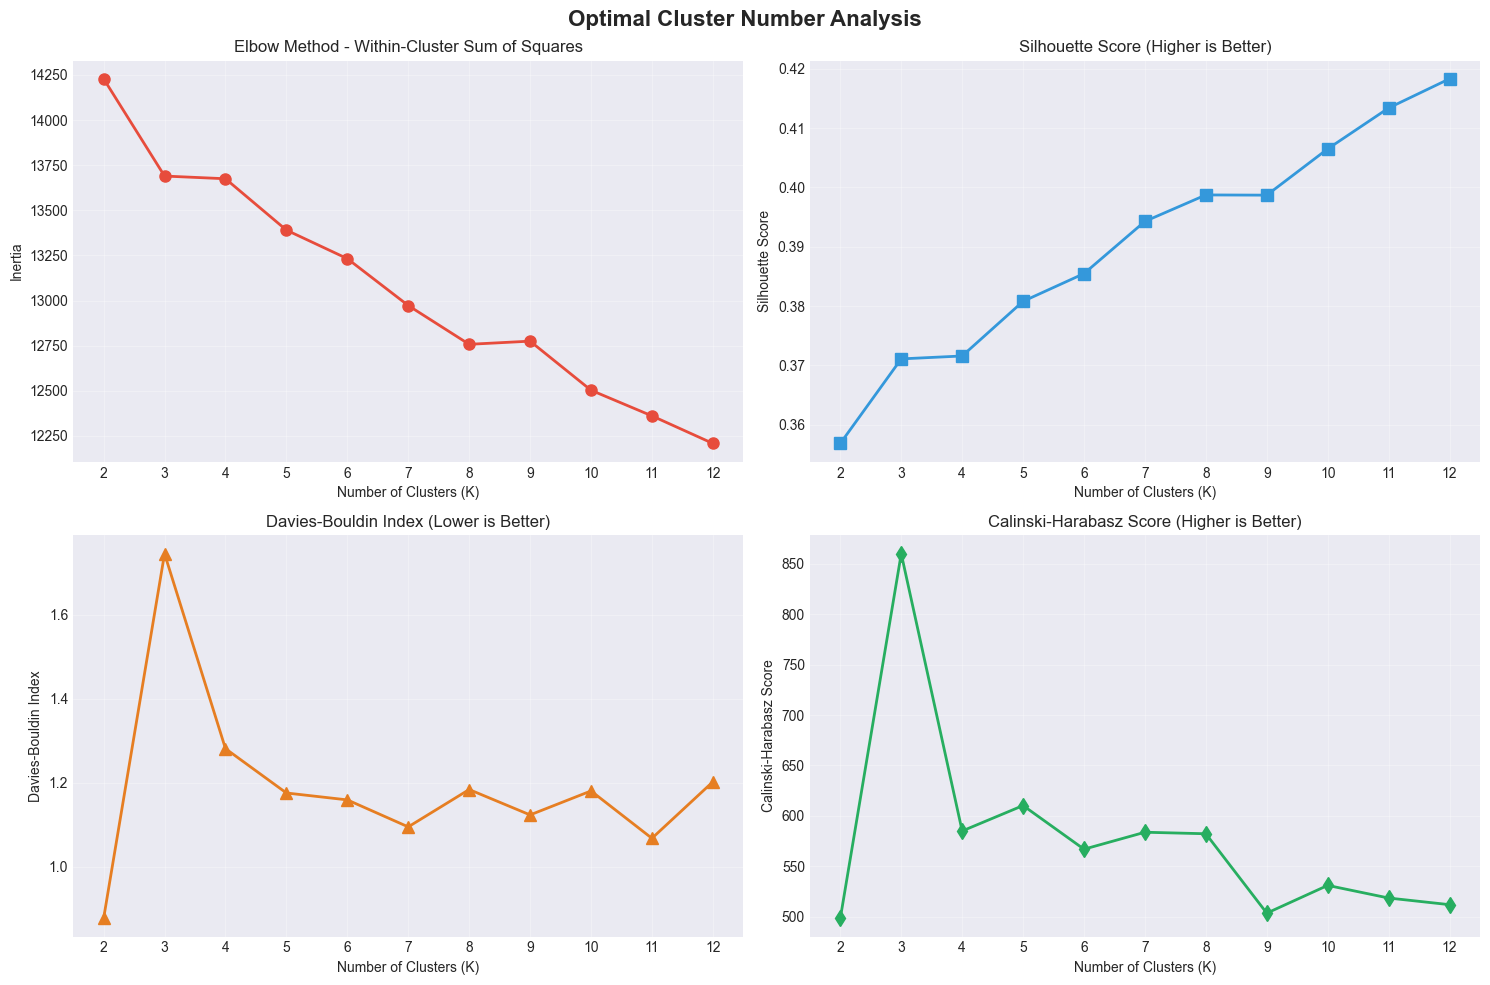


OPTIMAL CLUSTER RECOMMENDATIONS

📊 Based on Silhouette Score: K = 12 (score: 0.4183)
📊 Based on Calinski-Harabasz: K = 3 (score: 860.0)
📊 Recommendation: Use K = 12 clusters


In [15]:
# Find optimal number of clusters
print("Computing clustering metrics for K=2 to K=12...")
print("(This may take a minute...)\n")

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
K_range = range(2, 13)

# Convert sparse matrix to dense for metrics that require it
tfidf_dense = tfidf_matrix.toarray()

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(tfidf_dense, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(tfidf_dense, cluster_labels))
    
    print(f"K={k:2d} │ Inertia: {kmeans.inertia_:>10,.0f} │ Silhouette: {silhouette_scores[-1]:.4f} │ CH-Score: {calinski_harabasz_scores[-1]:>8.1f}")

print("\n✓ Cluster analysis complete!")

# Plot clustering metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Optimal Cluster Number Analysis', fontsize=16, fontweight='bold')

# Elbow method
axes[0, 0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='#E74C3C')
axes[0, 0].set_xlabel('Number of Clusters (K)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method - Within-Cluster Sum of Squares')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(K_range)

# Silhouette score
axes[0, 1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#3498DB')
axes[0, 1].set_xlabel('Number of Clusters (K)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(K_range)

# Davies-Bouldin Index
axes[1, 0].plot(K_range, davies_bouldin_scores, marker='^', linewidth=2, markersize=8, color='#E67E22')
axes[1, 0].set_xlabel('Number of Clusters (K)')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(K_range)

# Calinski-Harabasz Score
axes[1, 1].plot(K_range, calinski_harabasz_scores, marker='d', linewidth=2, markersize=8, color='#27AE60')
axes[1, 1].set_xlabel('Number of Clusters (K)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(K_range)

plt.tight_layout()
plt.show()

# Find optimal K
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_calinski = K_range[np.argmax(calinski_harabasz_scores)]

print(f"\n{'='*80}")
print(f"OPTIMAL CLUSTER RECOMMENDATIONS")
print(f"{'='*80}")
print(f"\n📊 Based on Silhouette Score: K = {optimal_k_silhouette} (score: {max(silhouette_scores):.4f})")
print(f"📊 Based on Calinski-Harabasz: K = {optimal_k_calinski} (score: {max(calinski_harabasz_scores):.1f})")
print(f"📊 Recommendation: Use K = {optimal_k_silhouette} clusters")

## Section 9: K-Means Clustering with Optimal K

In [17]:
# Perform K-Means clustering with optimal K
optimal_k = optimal_k_silhouette
print(f"Performing K-Means clustering with K={optimal_k}...\n")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels_kmeans = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels to dataframe
search_df['kmeans_cluster'] = cluster_labels_kmeans

print(f"{'='*80}")
print(f"K-MEANS CLUSTERING RESULTS (K={optimal_k})")
print(f"{'='*80}")
print(f"\n✓ Clustering complete!")
print(f"✓ Silhouette Score: {silhouette_score(tfidf_matrix, cluster_labels_kmeans):.4f}")
print(f"✓ Davies-Bouldin Index: {davies_bouldin_score(tfidf_dense, cluster_labels_kmeans):.4f}")

print(f"\n📊 Cluster Size Distribution:")
cluster_sizes = search_df['kmeans_cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    pct = size / len(search_df) * 100
    bar_length = int(pct / 2)
    print(f"   Cluster {cluster_id}: {size:>6,} ({pct:>5.1f}%) │ {'█' * bar_length}")

# Analyze cluster characteristics
print(f"\n{'='*80}")
print(f"CLUSTER CHARACTERISTICS & TOP KEYWORDS")
print(f"{'='*80}\n")

for cluster_id in range(optimal_k):
    cluster_queries = search_df[search_df['kmeans_cluster'] == cluster_id]['search_query'].values
    
    # Get top keywords for this cluster
    cluster_keywords = []
    for query in cluster_queries:
        cluster_keywords.extend(extract_keywords(query))
    
    top_keywords = Counter(cluster_keywords).most_common(8)
    
    print(f"\n🔹 CLUSTER {cluster_id} ({len(cluster_queries)} queries)")
    print(f"   {'─'*76}")
    print(f"   Top Keywords: {', '.join([kw for kw, _ in top_keywords])}")
    print(f"   Sample Queries:")
    
    # Show up to 5 sample queries
    for idx, query in enumerate(cluster_queries[:5], 1):
        query_display = query[:65] + "..." if len(query) > 65 else query
        print(f"      {idx}. {query_display}")
    
    if len(cluster_queries) > 5:
        print(f"      ... and {len(cluster_queries) - 5} more")

Performing K-Means clustering with K=12...

K-MEANS CLUSTERING RESULTS (K=12)

✓ Clustering complete!
K-MEANS CLUSTERING RESULTS (K=12)

✓ Clustering complete!
✓ Silhouette Score: 0.4193
✓ Davies-Bouldin Index: 1.1315

📊 Cluster Size Distribution:
   Cluster 0: 27,088 ( 88.7%) │ ████████████████████████████████████████████
   Cluster 1:    280 (  0.9%) │ 
   Cluster 2:    218 (  0.7%) │ 
   Cluster 3:    192 (  0.6%) │ 
   Cluster 4:    153 (  0.5%) │ 
   Cluster 5:    359 (  1.2%) │ 
   Cluster 6:    630 (  2.1%) │ █
   Cluster 7:    167 (  0.5%) │ 
   Cluster 8:    715 (  2.3%) │ █
   Cluster 9:    250 (  0.8%) │ 
   Cluster 10:    179 (  0.6%) │ 
   Cluster 11:    304 (  1.0%) │ 

CLUSTER CHARACTERISTICS & TOP KEYWORDS


🔹 CLUSTER 0 (27088 queries)
   ────────────────────────────────────────────────────────────────────────────
   Top Keywords: best, lucknow, venture, google, app, price, calorie, apple
   Sample Queries:
      1. elon musk shivon zilis
      2. bank station fire aler

## Section 10: Hierarchical Clustering Analysis

Performing Hierarchical Agglomerative Clustering...
(This may take a minute...)

✓ Hierarchical clustering complete!
✓ Silhouette Score: 0.4150

Generating dendrogram (using sample of 50 queries for visualization)...



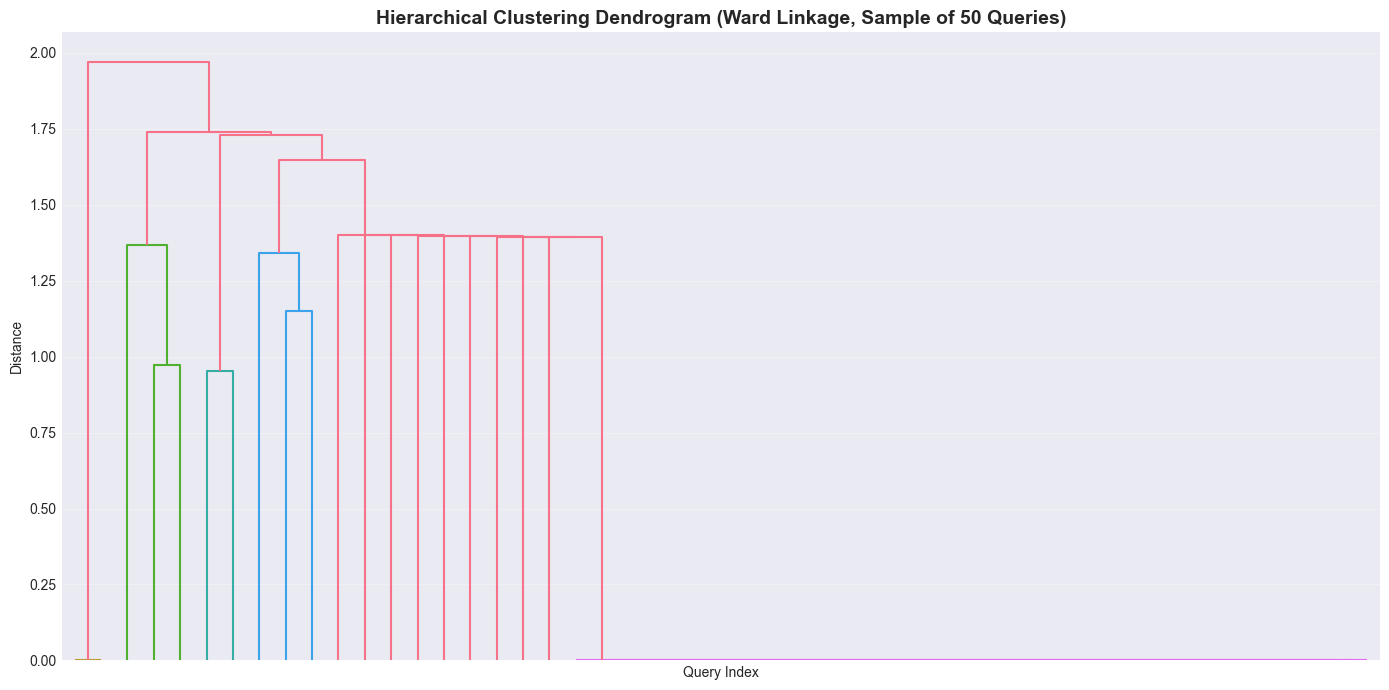

✓ Dendrogram created successfully!

CLUSTERING METHOD COMPARISON



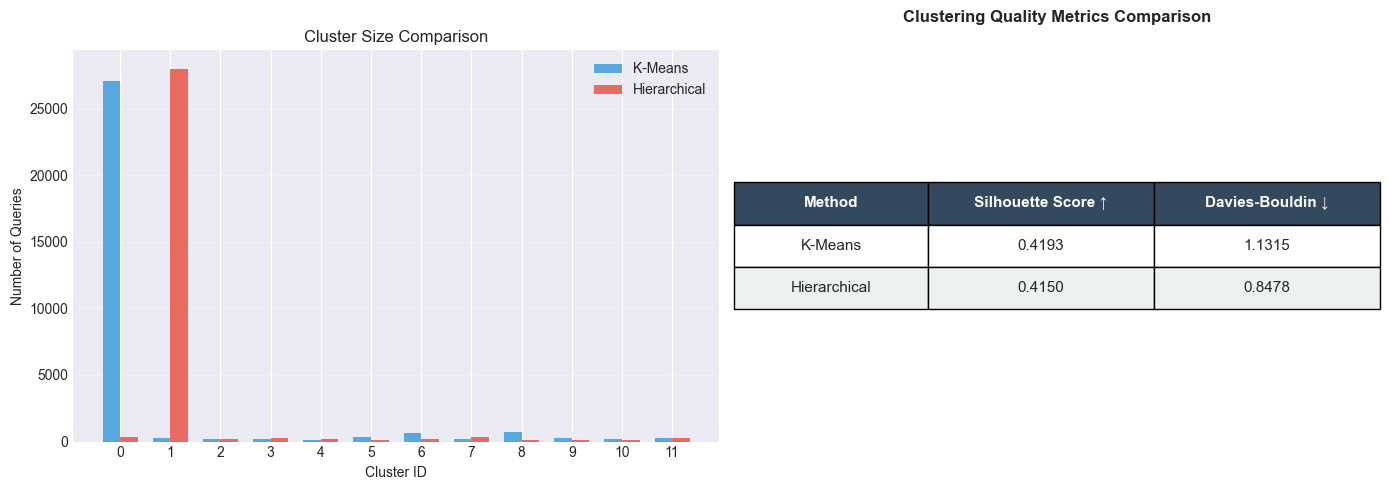


📊 Best Method: K-Means
   (based on higher Silhouette Score)


In [18]:
# Hierarchical clustering
print("Performing Hierarchical Agglomerative Clustering...")
print("(This may take a minute...)\n")

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
cluster_labels_hierarchical = hierarchical.fit_predict(tfidf_matrix.toarray())
search_df['hierarchical_cluster'] = cluster_labels_hierarchical

print(f"✓ Hierarchical clustering complete!")
print(f"✓ Silhouette Score: {silhouette_score(tfidf_matrix, cluster_labels_hierarchical):.4f}")

# Create dendrogram (on a sample for visualization)
print("\nGenerating dendrogram (using sample of 50 queries for visualization)...\n")

sample_size = min(50, len(search_queries_clean))
sample_indices = np.random.choice(len(search_queries_clean), sample_size, replace=False)
sample_tfidf = tfidf_matrix[sample_indices].toarray()

linkage_matrix = linkage(sample_tfidf, method='ward')

fig, ax = plt.subplots(figsize=(14, 7))
dendrogram(linkage_matrix, ax=ax, no_labels=True)
ax.set_title('Hierarchical Clustering Dendrogram (Ward Linkage, Sample of 50 Queries)', fontsize=14, fontweight='bold')
ax.set_xlabel('Query Index')
ax.set_ylabel('Distance')
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("✓ Dendrogram created successfully!")

# Cluster size comparison
print(f"\n{'='*80}")
print(f"CLUSTERING METHOD COMPARISON")
print(f"{'='*80}\n")

comparison_data = {
    'K-Means': search_df['kmeans_cluster'].value_counts().sort_index().values,
    'Hierarchical': search_df['hierarchical_cluster'].value_counts().sort_index().values,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(optimal_k)
width = 0.35

axes[0].bar(x_pos - width/2, comparison_data['K-Means'], width, label='K-Means', alpha=0.8, color='#3498DB')
axes[0].bar(x_pos + width/2, comparison_data['Hierarchical'], width, label='Hierarchical', alpha=0.8, color='#E74C3C')
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Number of Queries')
axes[0].set_title('Cluster Size Comparison')
axes[0].set_xticks(x_pos)
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Create summary table
methods = ['K-Means', 'Hierarchical']
silhouette_vals = [
    silhouette_score(tfidf_matrix, cluster_labels_kmeans),
    silhouette_score(tfidf_matrix, cluster_labels_hierarchical)
]
davies_bouldin_vals = [
    davies_bouldin_score(tfidf_dense, cluster_labels_kmeans),
    davies_bouldin_score(tfidf_dense, cluster_labels_hierarchical)
]

axes[1].axis('off')
table_data = []
for method, sil, db in zip(methods, silhouette_vals, davies_bouldin_vals):
    table_data.append([method, f'{sil:.4f}', f'{db:.4f}'])

table = axes[1].table(cellText=table_data, 
                       colLabels=['Method', 'Silhouette Score ↑', 'Davies-Bouldin ↓'],
                       cellLoc='center', loc='center',
                       colWidths=[0.3, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Color header
for i in range(3):
    table[(0, i)].set_facecolor('#34495E')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows alternately
for i in range(1, 3):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ECF0F1')
        else:
            table[(i, j)].set_facecolor('white')

axes[1].set_title('Clustering Quality Metrics Comparison', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n📊 Best Method: K-Means" if silhouette_vals[0] > silhouette_vals[1] else f"\n📊 Best Method: Hierarchical")
print(f"   (based on higher Silhouette Score)")

## Section 11: Visualization - Cluster Distributions & Insights

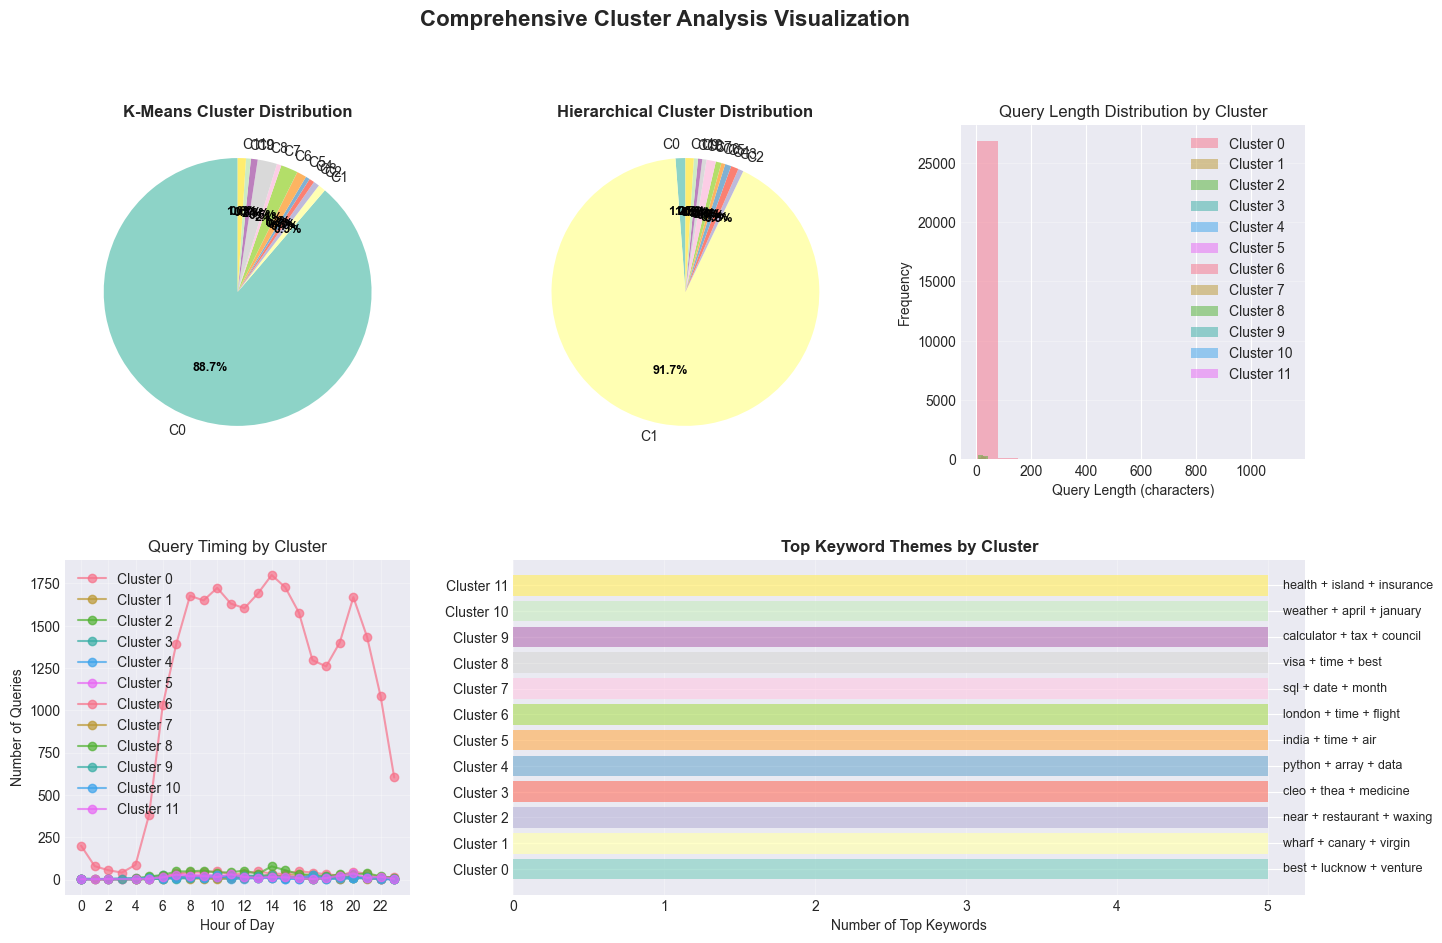

✓ Advanced cluster visualizations created!


In [25]:
# Advanced cluster visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Cluster size pie chart (K-Means)
ax1 = fig.add_subplot(gs[0, 0])
kmeans_counts = search_df['kmeans_cluster'].value_counts().sort_index()
colors = sns.color_palette("Set3", optimal_k)
wedges, texts, autotexts = ax1.pie(kmeans_counts.values, labels=[f'C{i}' for i in kmeans_counts.index],
                                     autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('K-Means Cluster Distribution', fontweight='bold')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# 2. Cluster size pie chart (Hierarchical)
ax2 = fig.add_subplot(gs[0, 1])
hier_counts = search_df['hierarchical_cluster'].value_counts().sort_index()
wedges, texts, autotexts = ax2.pie(hier_counts.values, labels=[f'C{i}' for i in hier_counts.index],
                                     autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Hierarchical Cluster Distribution', fontweight='bold')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# 3. Cluster query length distribution
ax3 = fig.add_subplot(gs[0, 2])
search_df['query_length'] = search_df['search_query'].str.len()
# Try to add hour data if available
if 'hour' not in search_df.columns:
    try:
        search_df['hour'] = df.loc[search_df.index, 'hour'] if len(search_df) <= len(df) else -1
    except:
        search_df['hour'] = -1

for cluster_id in range(optimal_k):
    cluster_data = search_df[search_df['kmeans_cluster'] == cluster_id]['query_length']
    ax3.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', bins=15)
ax3.set_xlabel('Query Length (characters)')
ax3.set_ylabel('Frequency')
ax3.set_title('Query Length Distribution by Cluster')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 4. Queries per hour by cluster
ax4 = fig.add_subplot(gs[1, 0])
try:
    if 'hour' in search_df.columns and search_df['hour'].notna().sum() > 0:
        for cluster_id in range(optimal_k):
            cluster_df_temp = search_df[search_df['kmeans_cluster'] == cluster_id].copy()
            hourly = cluster_df_temp['hour'].value_counts().sort_index()
            if len(hourly) > 0:
                ax4.plot(hourly.index, hourly.values, marker='o', label=f'Cluster {cluster_id}', alpha=0.7)
        ax4.set_xlabel('Hour of Day')
        ax4.set_ylabel('Number of Queries')
        ax4.set_title('Query Timing by Cluster')
        ax4.legend()
        ax4.grid(alpha=0.3)
        ax4.set_xticks(range(0, 24, 2))
    else:
        ax4.text(0.5, 0.5, 'Hour data not available', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Query Timing by Cluster (N/A)')
except Exception as e:
    ax4.text(0.5, 0.5, f'Error: {str(e)[:30]}', ha='center', va='center', transform=ax4.transAxes, fontsize=8)
    ax4.set_title('Query Timing - Error')

# 5. Top keywords per cluster - bar chart
ax5 = fig.add_subplot(gs[1, 1:])
top_keywords_by_cluster = {}
for cluster_id in range(optimal_k):
    cluster_queries = search_df[search_df['kmeans_cluster'] == cluster_id]['search_query'].values
    cluster_keywords = []
    for query in cluster_queries:
        cluster_keywords.extend(extract_keywords(query, n_words=10))
    top_kw = [kw for kw, _ in Counter(cluster_keywords).most_common(5)]
    top_keywords_by_cluster[f'C{cluster_id}'] = top_kw

# Create grouped bar chart
y_pos = np.arange(optimal_k)
for idx, (cluster_name, keywords) in enumerate(top_keywords_by_cluster.items()):
    label = ' + '.join(keywords[:3]) if keywords else 'N/A'
    ax5.barh(idx, len(keywords) if len(keywords) > 0 else 1, alpha=0.7, label=cluster_name, color=colors[idx])
    ax5.text(max(len(keywords), 1) + 0.1, idx, label[:50], va='center', fontsize=9)

ax5.set_yticks(range(optimal_k))
ax5.set_yticklabels([f'Cluster {i}' for i in range(optimal_k)])
ax5.set_xlabel('Number of Top Keywords')
ax5.set_title('Top Keyword Themes by Cluster', fontweight='bold')
ax5.grid(alpha=0.3, axis='x')

plt.suptitle('Comprehensive Cluster Analysis Visualization', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("✓ Advanced cluster visualizations created!")

## Section 12: Summary Report & Key Insights

In [26]:
# Generate comprehensive summary report
print(f"\n{'='*80}")
print(f"COMPREHENSIVE DATA ANALYSIS & CLUSTERING SUMMARY REPORT")
print(f"{'='*80}\n")

print(f"📋 DATASET OVERVIEW")
print(f"{'─'*80}")
print(f"Total Records: {len(df):,}")
print(f"Date Range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n📊 ACTIVITY BREAKDOWN")
print(f"{'─'*80}")
for activity, count in df['activity_type'].value_counts().items():
    pct = count / len(df) * 100
    print(f"{activity:.<25} {count:>8,} ({pct:>5.1f}%)")

print(f"\n🔍 SEARCH ANALYSIS")
print(f"{'─'*80}")
print(f"Total Searches: {len(search_df):,}")
print(f"Unique Searches: {search_df['search_query'].nunique():,}")
print(f"Repeat Search %: {(1 - search_df['search_query'].nunique()/len(search_df))*100:.1f}%")

print(f"\n🏷️ KEYWORD ANALYSIS")
print(f"{'─'*80}")
print(f"Total Unique Keywords: {len(keyword_freq):,}")
print(f"Top Keyword: {keyword_freq.most_common(1)[0][0]} ({keyword_freq.most_common(1)[0][1]} occurrences)")
print(f"Average Keyword Frequency: {np.mean([count for _, count in keyword_freq.items()]):.2f}")

print(f"\n🎯 CLUSTERING RESULTS (K-MEANS, K={optimal_k})")
print(f"{'─'*80}")
print(f"Silhouette Score: {silhouette_score(tfidf_matrix, cluster_labels_kmeans):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(tfidf_dense, cluster_labels_kmeans):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(tfidf_dense, cluster_labels_kmeans):.2f}")
print(f"Cluster Distribution: {dict(search_df['kmeans_cluster'].value_counts().sort_index())}")

print(f"\n⏰ TEMPORAL PATTERNS")
print(f"{'─'*80}")
peak_hour = df['hour'].value_counts().idxmax()
peak_day = df['day_of_week'].value_counts().idxmax()
print(f"Peak Activity Hour: {peak_hour}:00 ({df[df['hour']==peak_hour].shape[0]} activities)")
print(f"Peak Activity Day: {peak_day} ({df[df['day_of_week']==peak_day].shape[0]} activities)")
print(f"Average Activities per Day: {len(df) / (df['timestamp'].max() - df['timestamp'].min()).days:.1f}")

print(f"\n🌐 TOP DOMAINS")
print(f"{'─'*80}")
top_5_domains = df['domain'].value_counts().head(5)
for idx, (domain, count) in enumerate(top_5_domains.items(), 1):
    if domain:
        print(f"{idx}. {domain:.<50} {count:>6,}")

print(f"\n{'='*80}")
print(f"✅ ANALYSIS COMPLETE!")
print(f"{'='*80}")

print(f"\n📝 KEY FINDINGS:")
print(f"  • User shows consistent search behavior with {len(keyword_freq):,} unique topics")
print(f"  • Data contains {optimal_k} distinct interest clusters")
print(f"  • Peak activity occurs at {peak_hour}:00 on {peak_day}s")
print(f"  • Search behavior is concentrated (only {search_df['search_query'].nunique()/len(search_df)*100:.1f}% are unique)")
print(f"  • Top keywords: {', '.join([kw for kw, _ in keyword_freq.most_common(5)])}")


COMPREHENSIVE DATA ANALYSIS & CLUSTERING SUMMARY REPORT

📋 DATASET OVERVIEW
────────────────────────────────────────────────────────────────────────────────
Total Records: 55,383
Date Range: 2017-06-08 to 2024-06-23
Duration: 2572 days
Memory Usage: 56.38 MB

📊 ACTIVITY BREAKDOWN
────────────────────────────────────────────────────────────────────────────────
search_query.............   30,542 ( 55.1%)
page_visit...............   22,496 ( 40.6%)
other....................    2,187 (  3.9%)
notification.............      158 (  0.3%)

🔍 SEARCH ANALYSIS
────────────────────────────────────────────────────────────────────────────────
Total Searches: 30,535
Unique Searches: 25,807
Repeat Search %: 15.5%

🏷️ KEYWORD ANALYSIS
────────────────────────────────────────────────────────────────────────────────
Total Unique Keywords: 14,217
Top Keyword: london (657 occurrences)
Average Keyword Frequency: 5.74

🎯 CLUSTERING RESULTS (K-MEANS, K=12)
───────────────────────────────────────────────────